# Projet Data Science - Simulateur de DPE
## ENSAE Paris - 2A

Membres du groupe : 
- Wiam LACHQER , Amine RAZIG , Julien BOUDIER

Ce projet Python a été créé dans le but de fournir des visualisations variées des données et de mettre en place un simulateur de Diagnostic de Performance Energétique (DPE) à partir de la base de données de l'ADEME (Agence de la Transition Écologique).

## Objectifs du Projet

1. **Visualisations de Données :** Le projet propose différentes visualisations des données issues de la base de l'ADEME. Ces visualisations permettent une compréhension approfondie des caractéristiques énergétiques des logements.

2. **Simulateur de DPE :** Un simulateur de DPE a été développé en utilisant les données de l'ADEME. Ce simulateur permet d'estimer la performance énergétique d'un logement en fonction de divers paramètres.

In [ ]:
!pip install -q -r requirements.txt

In [2]:
import fetchdata

df = fetchdata.get_dpe(100000)
df.head()


Fetched 10000 observations
Fetched 20000 observations
Fetched 30000 observations
Fetched 40000 observations
Fetched 50000 observations
Fetched 60000 observations
Fetched 70000 observations
Fetched 80000 observations
Fetched 90000 observations
Fetched 100000 observations


,Type_énergie_n°3,Type_énergie_n°1,Type_énergie_n°2,Type_ventilation,Isolation_toiture_(0/1),Qualité_isolation_plancher_bas,Qualité_isolation_murs,Hauteur_sous-plafond,Surface_habitable_logement,Code_postal_(brut),Période_construction,Type_bâtiment,Type_énergie_principale_ECS,Type_énergie_principale_chauffage,Etiquette_DPE,_score
0,Électricité,Gaz naturel,Bois – Bûches,Ventilation par ouverture des fenêtres,False,très bonne,insuffisante,2.9,220.8,25000,avant 1948,appartement,Gaz naturel,Gaz naturel,D,None
1,NaN,Gaz naturel,Électricité,NaN,NaN,très bonne,insuffisante,2.5,50.0,13120,1948-1974,appartement,Gaz naturel,Électricité,D,None
2,NaN,Réseau de Chauffage urbain,Électricité,VMC SF Auto réglable avant 1982,NaN,insuffisante,insuffisante,2.5,80.0,73000,1948-1974,appartement,Réseau de Chauffage urbain,Réseau de Chauffage urbain,C,None
3,Électricité,Réseau de Chauffage urbain,Gaz naturel,NaN,NaN,insuffisante,insuffisante,2.5,47.5,44800,1975-1977,appartement,NaN,NaN,C,None
4,NaN,Électricité,Réseau de Chauffage urbain,NaN,NaN,très bonne,insuffisante,2.5,109.0,92340,1983-1988,appartement,Réseau de Chauffage urbain,Électricité,E,None


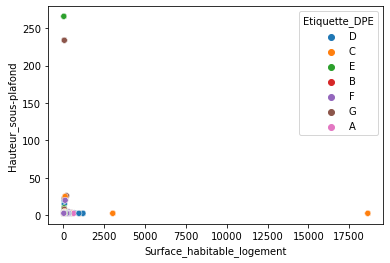

In [8]:
import eda

eda.scatterplot(df, "Surface_habitable_logement", "Hauteur_sous-plafond", "Etiquette_DPE")

In [4]:
# Importation des bibliothèques qu’on va utiliser
import fetchdata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [5]:
#Fonction qui permet d’explorer les données

def create_unique(df):
        
    df_unique = pd.DataFrame(columns=['Column_name','Data_type', 'Number_of_unique','Number_of_missing', 'Unique_values'])

    # loop through the columns in the other dataframe
    for col in df.columns:
        # get the number of unique values in the column
        num_unique = df[col].nunique()

        # add the unique values as a list to the 'Unique_values' column if num_unique <= 5
        if num_unique <= 15:
            unique_vals = list(df[col].unique())
        else:
            unique_vals = "More than 15 unique values"

        # get the data type of the column
        data_type = df[col].dtype

        # count the number of missing values in the column
        num_missing = df[col].isnull().sum()

        # append a row to the empty dataframe with the column name, number of unique values, unique values, and data type
        df_unique = pd.concat([df_unique,pd.DataFrame([{'Column_name': col, 'Number_of_unique': num_unique, 'Unique_values': unique_vals, 'Data_type':
                                      data_type, 'Number_of_missing': num_missing}])])
    return df_unique

Le simulateur de DPE en fonction d’informations accessibles pour le propriétaire et le locataire: 

In [6]:
create_unique(df)

,Column_name,Data_type,Number_of_unique,Number_of_missing,Unique_values
0,Type_énergie_n°3,object,11,76820,"[Électricité, nan, Bois – Bûches, GPL, Gaz nat..."
0,Type_énergie_n°1,object,12,0,"[Gaz naturel, Réseau de Chauffage urbain, Élec..."
0,Type_énergie_n°2,object,12,18400,"[Bois – Bûches, Électricité, Gaz naturel, Rése..."
0,Type_ventilation,object,35,31170,More than 15 unique values
0,Isolation_toiture_(0/1),object,2,64690,"[False, nan, True]"
0,Qualité_isolation_plancher_bas,object,4,1030,"[très bonne, insuffisante, bonne, moyenne, nan]"
0,Qualité_isolation_murs,object,4,0,"[insuffisante, très bonne, bonne, moyenne]"
0,Hauteur_sous-plafond,float64,41,0,More than 15 unique values
0,Surface_habitable_logement,float64,1701,1570,More than 15 unique values
0,Code_postal_(brut),object,2903,0,More than 15 unique values


## Mise en place de la base de données exploitable. 
L'objectif est de selectionner et de modifier certaines variables afin qu'elles puissent etre utilisées efficacement dans nos analyses.

In [7]:
# Traitement des données manquantes

# Suppression des colonnes avec plus de 60% des valeurs manquantes
df.drop(["Type_énergie_n°3","Isolation_toiture_(0/1)", "_score"], axis=1, inplace=True)

# Suppression des lignes dans lesquelles la surface habitable est non renseignée
df=df[df["Surface_habitable_logement"].notna()]
df=df[df["Qualité_isolation_plancher_bas"].notna()]

# Pour les données qui ont Type_énergie_principale_ECS=Nan ou Type_énergie_principale_chauffage=Nan, on remplit ces cases par Type_énergie_n°1
df["Type_énergie_principale_ECS"].fillna(df["Type_énergie_n°1"], inplace = True)
df["Type_énergie_principale_chauffage"].fillna(df["Type_énergie_n°1"], inplace = True)

# Remplacez tous les types de bois dans la varaible 'Type_énergie_principale_chauffage' par 'bois'
df['Type_énergie_principale_chauffage'] = df['Type_énergie_principale_chauffage'].replace(['Bois – Bûches','Bois – Granulés (pellets) ou briquettes', 'Bois – Plaquettes d’industrie', 'Bois – Plaquettes forestières'], 'Bois')
# Remplacez tous les types de bois dans la varaible 'Type_énergie_principale_ECS' par 'bois'
df['Type_énergie_principale_ECS'] = df['Type_énergie_principale_ECS'].replace(['Bois – Bûches','Bois – Granulés (pellets) ou briquettes', 'Bois – Plaquettes d’industrie', 'Bois – Plaquettes forestières'], 'Bois')

# La simulation portera uniquement sur les maisons et les appartements, on supprime les immeubles
df=df[df["Type_bâtiment"]!="immeuble"]

# L’encodage des variables non numériques
label_encoder = LabelEncoder()
df['Qualité_isolation_plancher_bas_encoded'] = label_encoder.fit_transform(df['Qualité_isolation_plancher_bas'])
df["Qualité_isolation_murs_encoded"] = label_encoder.fit_transform(df['Qualité_isolation_murs'])
df["Période_construction_encoded"] = label_encoder.fit_transform(df['Période_construction'])
df["Type_énergie_principale_ECS_encoded"] = label_encoder.fit_transform(df['Type_énergie_principale_ECS'])
df["Type_énergie_principale_chauffage_encoded"] = label_encoder.fit_transform(df['Type_énergie_principale_chauffage'])
df["Période_construction_encoded"] = label_encoder.fit_transform(df['Période_construction'])
df = pd.get_dummies(df, columns=['Type_bâtiment'])

df



,Type_énergie_n°1,Type_énergie_n°2,Type_ventilation,Qualité_isolation_plancher_bas,Qualité_isolation_murs,Hauteur_sous-plafond,Surface_habitable_logement,Code_postal_(brut),Période_construction,Type_énergie_principale_ECS,Type_énergie_principale_chauffage,Etiquette_DPE,Qualité_isolation_plancher_bas_encoded,Qualité_isolation_murs_encoded,Période_construction_encoded,Type_énergie_principale_ECS_encoded,Type_énergie_principale_chauffage_encoded,Type_bâtiment_appartement,Type_bâtiment_maison
0,Gaz naturel,Bois – Bûches,Ventilation par ouverture des fenêtres,très bonne,insuffisante,2.9,220.8,25000,avant 1948,Gaz naturel,Gaz naturel,D,3,1,9,3,4,1,0
1,Gaz naturel,Électricité,NaN,très bonne,insuffisante,2.5,50.0,13120,1948-1974,Gaz naturel,Électricité,D,3,1,0,3,7,1,0
2,Réseau de Chauffage urbain,Électricité,VMC SF Auto réglable avant 1982,insuffisante,insuffisante,2.5,80.0,73000,1948-1974,Réseau de Chauffage urbain,Réseau de Chauffage urbain,C,1,1,0,5,6,1,0
3,Réseau de Chauffage urbain,Gaz naturel,NaN,insuffisante,insuffisante,2.5,47.5,44800,1975-1977,Réseau de Chauffage urbain,Réseau de Chauffage urbain,C,1,1,1,5,6,1,0
4,Électricité,Réseau de Chauffage urbain,NaN,très bonne,insuffisante,2.5,109.0,92340,1983-1988,Réseau de Chauffage urbain,Électricité,E,3,1,3,5,7,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,Électricité,NaN,VMC SF Hygro A avant 2001,très bonne,moyenne,2.5,89.4,93160,1989-2000,Électricité,Électricité,D,3,2,4,6,7,1,0
99996,Gaz naturel,Gaz naturel,NaN,insuffisante,insuffisante,2.5,84.2,62400,1948-1974,Gaz naturel,Gaz naturel,E,1,1,0,3,4,0,1
99997,Électricité,NaN,VMC SF Auto réglable avant 1982,insuffisante,bonne,2.2,18.2,37000,avant 1948,Électricité,Électricité,F,1,0,9,6,7,1,0
99998,Électricité,NaN,VMC SF Auto réglable de 1982 à 2000,très bonne,bonne,2.5,35.4,94160,1989-2000,Électricité,Électricité,C,3,0,4,6,7,1,0


In [8]:
df['Qualité_isolation_plancher_bas'].unique()

array(['très bonne', 'insuffisante', 'bonne', 'moyenne'], dtype=object)

## Analyse descriptive de la base de donnée : 
- répartition des types d'énergies principaux des logements ?
- type de chauffage utilisé en majorité selon la note de l'étiquette DPE ? 
- etiquette DPE en fonction des codes postaux (représentation cartographique ? ) rq => ajouter dans la base de donnéee les données géo
- etiquette DPE en fonction de l'année de construction ?
- surface habitable 

rq :  quels sont les variables cibles dans la base ? on cherche a prédri les consos, les émissions etc... Objectifs avec ces variables est de faire un indicateur de performanace énergétiques et ensuite de le prédire. 

Méthodologie => se baser sur la litterature pour comprendre les indicateurs majeur de performance énergetique, création de l'indice en attribuant des poids aux varaibles cibles, les normaliser ? moyenne ? 




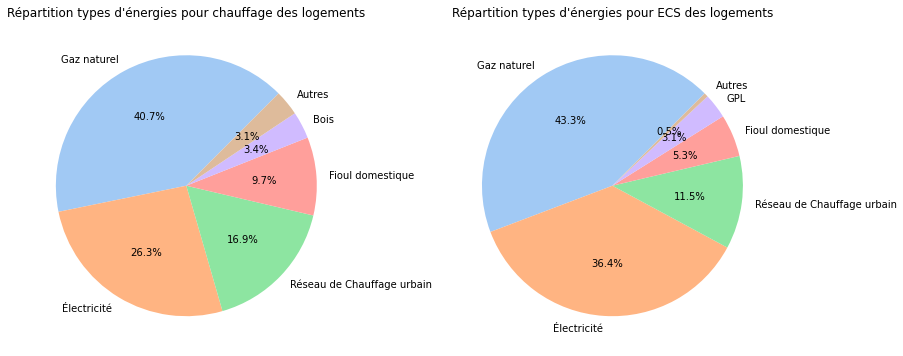

In [10]:
# Analyse descriptive de la base de donnée : 
bd_dpe = df.copy()

# répartition des types d'energies de chauffage  des logements : 
comptage_type_chauffage = bd_dpe['Type_énergie_principale_chauffage'].value_counts()
comptage_type_ECS = bd_dpe['Type_énergie_principale_ECS'].value_counts()


### REPRESENTATION GRAPHIQUE 
# Calcul des pourcentages pour chaque type d'énergie
pourcentages_chauffage = (comptage_type_chauffage / len(bd_dpe)) * 100
pourcentages_ECS = (comptage_type_ECS / len(bd_dpe)) * 100

# Seuil pour regrouper les petites catégories sous "Autres"
seuil = 3

# Regroupement des petites catégories sous "Autres" si leur pourcentage est inférieur au seuil
autres_chauffage = pourcentages_chauffage[pourcentages_chauffage < seuil].sum()
autres_ECS = pourcentages_ECS[pourcentages_ECS < seuil].sum()

# Création de nouveaux tableaux pour le graphique avec "Autres"
nouveaux_pourcentages_chauffage = pourcentages_chauffage[pourcentages_chauffage >= seuil]
nouveaux_pourcentages_chauffage['Autres'] = autres_chauffage

nouveaux_pourcentages_ECS = pourcentages_ECS[pourcentages_ECS >= seuil]
nouveaux_pourcentages_ECS['Autres'] = autres_ECS

# Création des graphiques
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Graphique pour le chauffage
axes[0].pie(x=nouveaux_pourcentages_chauffage, labels=nouveaux_pourcentages_chauffage.index, startangle=45,
            colors=sns.color_palette('pastel', len(nouveaux_pourcentages_chauffage)), autopct='%1.1f%%')
axes[0].set_title('Répartition types d\'énergies pour chauffage des logements')

# Graphique pour l'ECS
axes[1].pie(x=nouveaux_pourcentages_ECS, labels=nouveaux_pourcentages_ECS.index, startangle=45,
            colors=sns.color_palette('pastel', len(nouveaux_pourcentages_ECS)), autopct='%1.1f%%')
axes[1].set_title('Répartition types d\'énergies pour ECS des logements')

# Affichage des graphiques
plt.show()


In [16]:
# Corrélation

corr = bd_dpe.corr()
corr.style.background_gradient(cmap='coolwarm')

,Hauteur_sous-plafond,Surface_habitable_logement,Qualité_isolation_plancher_bas_encoded,Qualité_isolation_murs_encoded,Période_construction_encoded,Type_énergie_principale_ECS_encoded,Type_énergie_principale_chauffage_encoded,Type_bâtiment_appartement,Type_bâtiment_maison
Hauteur_sous-plafond,1.000000,-0.001300,0.013897,-0.005738,0.030695,0.015603,0.013719,-0.002703,0.002703
Surface_habitable_logement,-0.001300,1.000000,-0.023963,-0.022944,0.035450,-0.003703,-0.060430,-0.130386,0.130386
Qualité_isolation_plancher_bas_encoded,0.013897,-0.023963,1.000000,0.053654,0.122112,0.006443,0.042645,0.189235,-0.189235
Qualité_isolation_murs_encoded,-0.005738,-0.022944,0.053654,1.000000,-0.065341,-0.011981,0.049820,0.116152,-0.116152
Période_construction_encoded,0.030695,0.035450,0.122112,-0.065341,1.000000,0.082306,-0.065117,-0.266187,0.266187
Type_énergie_principale_ECS_encoded,0.015603,-0.003703,0.006443,-0.011981,0.082306,1.000000,0.480781,-0.010764,0.010764
Type_énergie_principale_chauffage_encoded,0.013719,-0.060430,0.042645,0.049820,-0.065117,0.480781,1.000000,0.216447,-0.216447
Type_bâtiment_appartement,-0.002703,-0.130386,0.189235,0.116152,-0.266187,-0.010764,0.216447,1.000000,-1.000000
Type_bâtiment_maison,0.002703,0.130386,-0.189235,-0.116152,0.266187,0.010764,-0.216447,-1.000000,1.000000


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (9,) and arg 1 with shape (8,).

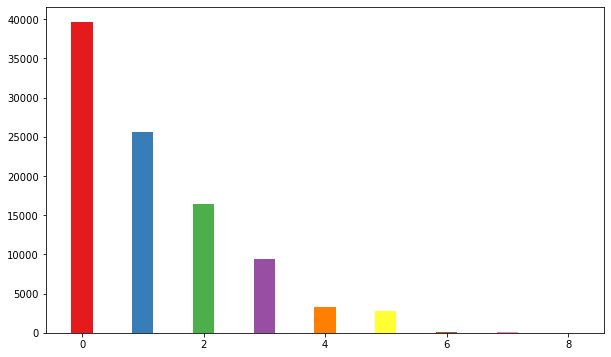

In [11]:

# TYPE DE REPRESENTATIONA REVOIR /!\ pas tres visuelle

# Comptage pour 'Type_énergie_principale_chauffage'
comptage_type_chauffage = bd_dpe['Type_énergie_principale_chauffage'].value_counts()
colors_ECS = sns.color_palette('Set2')[0:len(comptage_type_ECS)]

# Comptage pour 'type_principale_energie_ECS'
comptage_type_ECS = bd_dpe['Type_énergie_principale_ECS'].value_counts()
colors_chauffage = sns.color_palette('Set1')[0:len(comptage_type_chauffage)]

# Création du graphique en barres superposées
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = range(len(comptage_type_chauffage))

# Barres pour 'Type_énergie_principale_chauffage'
plt.bar(index, comptage_type_chauffage, bar_width, color=colors_chauffage, label='Chauffage')

# Barres pour 'type_principale_energie_ECS'
plt.bar(index, comptage_type_ECS, bar_width, color=colors_ECS, label='ECS', alpha=0.7)

# Ajout des labels, titres, et légende
plt.xlabel('Types d\'énergies')
plt.ylabel('Nombre d\'occurrences')
plt.title('Répartition des types d\'énergies pour chauffage et ECS des logements')
plt.xticks(index, comptage_type_chauffage.index)
plt.legend()

# Affichage du graphique
plt.show()

In [277]:
create_unique(df)

,Column_name,Data_type,Number_of_unique,Number_of_missing,Unique_values
0,Type_énergie_n°1,object,11,0,"[Gaz naturel, Réseau de Chauffage urbain, Élec..."
0,Type_énergie_n°2,object,10,1684,"[Bois – Bûches, Électricité, Gaz naturel, nan,..."
0,Type_ventilation,object,36,3112,More than 15 unique values
0,Qualité_isolation_plancher_bas,object,4,0,"[très bonne, insuffisante, moyenne, bonne]"
0,Qualité_isolation_murs,object,4,0,"[insuffisante, bonne, très bonne, moyenne]"
0,Hauteur_sous-plafond,float64,39,0,More than 15 unique values
0,Surface_habitable_logement,float64,1683,0,More than 15 unique values
0,Code_postal_(brut),object,2856,0,More than 15 unique values
0,Période_construction,object,10,0,"[avant 1948, 1948-1974, 1975-1977, 2006-2012, ..."
0,Type_énergie_principale_ECS,object,11,0,"[Gaz naturel, Réseau de Chauffage urbain, Élec..."


Analyse de corrélations (via des graphes et probablement une carte)

In [262]:
# Répartition des données entre données d’entrainement et celles de validation
x=df.iloc[:,[5,6,7,12,13,14,15,16,17,19,20]]
y=df["Etiquette_DPE"]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1)


In [280]:
#instanciation
model_DT = DecisionTreeClassifier()
#training
model_DT.fit(X_train, y_train)
#Prédiction
prediction = model_DT.predict(X_test)
# Evaluation
print(model_DT.score(X_train, y_train))
print(model_DT.score(X_test, y_test))

scores = cross_val_score(model_DT, x, y, cv=5)
print(scores)

# MAUVAISE PERFORMANCE (OVERFITTING)


0.990755535265921
0.4948665297741273
[0.50256674 0.48741654 0.49357987 0.46533128 0.47817155]


In [279]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)  # Vous pouvez ajuster les hyperparamètres selon vos besoins

# Entraînez le classificateur sur l'ensemble d'entraînement
clf.fit(X_train, y_train)

# Faites des prédictions sur l'ensemble de test
y_pred = clf.predict(X_test)

# Évaluez les performances du modèle
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# A REVOIR, JE COMPRENDS PAS TROP CES GRANDEURS

Accuracy: 0.5523613963039015
Classification Report:
              precision    recall  f1-score   support

           A       0.00      0.00      0.00         6
           B       0.70      0.50      0.58        32
           C       0.73      0.73      0.73       332
           D       0.50      0.60      0.54       284
           E       0.43      0.41      0.42       189
           F       0.30      0.25      0.27        72
           G       0.39      0.22      0.28        59

    accuracy                           0.55       974
   macro avg       0.43      0.39      0.40       974
weighted avg       0.55      0.55      0.55       974

Confusion Matrix:
[[  0   2   3   1   0   0   0]
 [  0  16  11   5   0   0   0]
 [  1   3 243  67  17   1   0]
 [  0   1  61 171  38  11   2]
 [  0   1   9  68  77  22  12]
 [  0   0   2  20  26  18   6]
 [  0   0   3  12  23   8  13]]
